# Setting Environment

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.3 MB/s eta 0:00:00


In [ ]:
import sys

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Utils Functions

In [ ]:
import torch

SEED = 1111
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

max_input_length = 180

512


In [ ]:
def tokenize_bert(sentence):
    tokens = tokenizer.tokenize(sentence) 
    return tokens

In [ ]:
def split_and_cut(sentence):
    tokens = sentence.strip().split(" ")
    tokens = tokens[:max_input_length-1]
    return tokens

In [ ]:
def trim_sentence(sent):
    try:
        sent = sent.split()
        sent = sent[:90]
        return " ".join(sent)
    except:
        return sent

# Download Dataset

In [ ]:
!wget  https://cims.nyu.edu/~sbowman/multinli/multinli_1.0.zip

--2023-05-13 13:03:11--  https://cims.nyu.edu/~sbowman/multinli/multinli_1.0.zip
Resolving cims.nyu.edu (cims.nyu.edu)... 216.165.22.202
Connecting to cims.nyu.edu (cims.nyu.edu)|216.165.22.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226850426 (216M) [application/zip]
Saving to: ‘multinli_1.0.zip’

multinli_1.0.zip    100%[===================>] 216.34M  31.0MB/s    in 7.4s    

2023-05-13 13:03:19 (29.4 MB/s) - ‘multinli_1.0.zip’ saved [226850426/226850426]



In [ ]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "multinli_1.0.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
multinli_1.0/                                  2018-04-15 22:06:08            0
multinli_1.0/multinli_1.0_dev_mismatched.jsonl 2017-09-03 17:34:52     13460535
multinli_1.0/paper.pdf                         2018-04-15 22:02:54       196418
__MACOSX/                                      2018-04-15 22:06:32            0
__MACOSX/multinli_1.0/                         2018-04-15 22:06:32            0
__MACOSX/multinli_1.0/._paper.pdf              2018-04-15 22:02:54         1128
multinli_1.0/.DS_Store                         2018-04-15 22:06:04         6148
__MACOSX/multinli_1.0/._.DS_Store              2018-04-15 22:06:04          120
multinli_1.0/multinli_1.0_train.jsonl          2017-09-03 17:35:46    492421641
multinli_1.0/multinli_1.0_dev_mismatched.txt   2017-09-03 17:34:52     11170082
                             2018-02-16 16:46:20            0
                  2018-02-16 16:46:20       384959
multinl

# Prepare Dataset

In [ ]:
def get_sent1_token_type(sent):
    try:
        return [0]* len(sent)
    except:
        return []

def get_sent2_token_type(sent):
    try:
        return [1]* len(sent)
    except:
        return []
    
def combine_seq(seq):
    return " ".join(seq)

def combine_mask(mask):
    mask = [str(m) for m in mask]
    return " ".join(mask)

In [ ]:
import json
from tqdm import tqdm
def getDataset(dataset_name="mnli"):
    if dataset_name=="mnli":
        filepath_train="multinli_1.0/multinli_1.0_train.jsonl"
        filepath_dev="multinli_1.0/multinli_1.0_dev_matched.jsonl"
        filepath_test="multinli_1.0/multinli_1.0_dev_mismatched.jsonl"
    elif dataset_name=="snli":
        filepath_train="../data/snli_1.0/snli_1.0/snli_1.0_train.jsonl"
        filepath_dev="../data/snli_1.0/snli_1.0/snli_1.0_dev.jsonl"
        filepath_test="../data/snli_1.0/snli_1.0/snli_1.0_test.jsonl"
    else:
        print("Invalid dataset name")
        return None
    
    #read train,dev and test data
    labels = ["contradiction", "entailment", "neutral"]
    f= open(filepath_train, "r")
    data = list(f)
    train_dataset={"sentence1":[],"sentence2":[],"gold_label":[]}
    print("train data")
    for line in tqdm(data):
        line = json.loads(line)
        if line['gold_label'] not in labels:
            # print(line['gold_label'])
            continue
        train_dataset["sentence1"].append(line['sentence1'])
        train_dataset["sentence2"].append(line['sentence2'])
        train_dataset["gold_label"].append(line['gold_label'])
    f.close()

    f= open(filepath_dev, "r")
    data = list(f)
    dev_dataset={"sentence1":[],"sentence2":[],"gold_label":[]}
    print("dev data")
    for line in tqdm(data):
        line = json.loads(line)
        if line['gold_label'] not in labels:
            # print(line['gold_label'])
            continue
        dev_dataset["sentence1"].append(line['sentence1'])
        dev_dataset["sentence2"].append(line['sentence2'])
        dev_dataset["gold_label"].append(line['gold_label'])
    f.close()

    f= open(filepath_test, "r")
    data = list(f)
    test_dataset={"sentence1":[],"sentence2":[],"gold_label":[]}
    print("test data")
    for line in tqdm(data):
        line = json.loads(line)
        if line['gold_label'] not in labels:
            # print(line['gold_label'])
            continue
        test_dataset["sentence1"].append(line['sentence1'])
        test_dataset["sentence2"].append(line['sentence2'])
        test_dataset["gold_label"].append(line['gold_label'])
    f.close()
    
    return train_dataset,dev_dataset,test_dataset

train_dataset,dev_dataset,test_dataset=getDataset()

train data


100%|██████████| 392702/392702 [00:09<00:00, 41793.28it/s] 


dev data


100%|██████████| 10000/10000 [00:00<00:00, 128663.97it/s]


test data


100%|██████████| 10000/10000 [00:00<00:00, 129375.16it/s]


In [ ]:
import pandas as pd

df_train = pd.DataFrame.from_dict(train_dataset)
df_dev = pd.DataFrame.from_dict(dev_dataset)
df_test = pd.DataFrame.from_dict(test_dataset)

df_train = df_train[['gold_label','sentence1','sentence2']]
df_dev = df_dev[['gold_label','sentence1','sentence2']]
df_test = df_test[['gold_label','sentence1','sentence2']]

df_train = df_train[:80000]
df_dev = df_dev[:8000]
df_test = df_test[:8000]


df_train['sentence1'] = df_train['sentence1'].apply(trim_sentence)
df_train['sentence2'] = df_train['sentence2'].apply(trim_sentence)
df_dev['sentence1'] = df_dev['sentence1'].apply(trim_sentence)
df_dev['sentence2'] = df_dev['sentence2'].apply(trim_sentence)
df_test['sentence1'] = df_test['sentence1'].apply(trim_sentence)
df_test['sentence2'] = df_test['sentence2'].apply(trim_sentence)

df_train['sent1'] = '[CLS] ' + df_train['sentence1'] + ' [SEP] '
df_train['sent2'] = df_train['sentence2'] + ' [SEP]'
df_dev['sent1'] = '[CLS] ' + df_dev['sentence1'] + ' [SEP] '
df_dev['sent2'] = df_dev['sentence2'] + ' [SEP]'
df_test['sent1'] = '[CLS] ' + df_test['sentence1'] + ' [SEP] '
df_test['sent2'] = df_test['sentence2'] + ' [SEP]'

df_train['sent1_t'] = df_train['sent1'].apply(tokenize_bert)
df_train['sent2_t'] = df_train['sent2'].apply(tokenize_bert)
df_dev['sent1_t'] = df_dev['sent1'].apply(tokenize_bert)
df_dev['sent2_t'] = df_dev['sent2'].apply(tokenize_bert)
df_test['sent1_t'] = df_test['sent1'].apply(tokenize_bert)
df_test['sent2_t'] = df_test['sent2'].apply(tokenize_bert)

df_train['sent1_token_type'] = df_train['sent1_t'].apply(get_sent1_token_type)
df_train['sent2_token_type'] = df_train['sent2_t'].apply(get_sent2_token_type)
df_dev['sent1_token_type'] = df_dev['sent1_t'].apply(get_sent1_token_type)
df_dev['sent2_token_type'] = df_dev['sent2_t'].apply(get_sent2_token_type)
df_test['sent1_token_type'] = df_test['sent1_t'].apply(get_sent1_token_type)
df_test['sent2_token_type'] = df_test['sent2_t'].apply(get_sent2_token_type)

df_train['sequence'] = df_train['sent1_t'] + df_train['sent2_t']
df_dev['sequence'] = df_dev['sent1_t'] + df_dev['sent2_t']
df_test['sequence'] = df_test['sent1_t'] + df_test['sent2_t']


df_train['attention_mask'] = df_train['sequence'].apply(get_sent2_token_type)
df_dev['attention_mask'] = df_dev['sequence'].apply(get_sent2_token_type)
df_test['attention_mask'] = df_test['sequence'].apply(get_sent2_token_type)

df_train['token_type'] = df_train['sent1_token_type'] + df_train['sent2_token_type']
df_dev['token_type'] = df_dev['sent1_token_type'] + df_dev['sent2_token_type']
df_test['token_type'] = df_test['sent1_token_type'] + df_test['sent2_token_type']

df_train['sequence'] = df_train['sequence'].apply(combine_seq)
df_dev['sequence'] = df_dev['sequence'].apply(combine_seq)
df_test['sequence'] = df_test['sequence'].apply(combine_seq)

df_train['attention_mask'] = df_train['attention_mask'].apply(combine_mask)
df_dev['attention_mask'] = df_dev['attention_mask'].apply(combine_mask)
df_test['attention_mask'] = df_test['attention_mask'].apply(combine_mask)

df_train['token_type'] = df_train['token_type'].apply(combine_mask)
df_dev['token_type'] = df_dev['token_type'].apply(combine_mask)
df_test['token_type'] = df_test['token_type'].apply(combine_mask)

df_train = df_train[['gold_label', 'sequence', 'attention_mask', 'token_type']]
df_dev = df_dev[['gold_label', 'sequence', 'attention_mask', 'token_type']]
df_test = df_test[['gold_label', 'sequence', 'attention_mask', 'token_type']]



df_train = df_train.loc[df_train['gold_label'].isin(['entailment','contradiction','neutral'])]
df_dev = df_dev.loc[df_dev['gold_label'].isin(['entailment','contradiction','neutral'])]
df_test = df_test.loc[df_test['gold_label'].isin(['entailment','contradiction','neutral'])]



df_train.to_csv('multinli_1.0/multinli_1.0_train.csv', index=False)
df_dev.to_csv('multinli_1.0/multinli_1.0_dev.csv', index=False)
df_test.to_csv('multinli_1.0/multinli_1.0_test.csv', index=False)

In [ ]:
print(df_train.iloc[0]['sequence'])
print(df_train.iloc[0]['attention_mask'])
print(df_train.iloc[0]['token_type'])

[CLS] conceptual ##ly cream ski ##mming has two basic dimensions - product and geography . [SEP] product and geography are what make cream ski ##mming work . [SEP]
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
def convert_to_int(tok_ids):
    tok_ids = [int(x) for x in tok_ids]
    return tok_ids

In [ ]:
def padding_tokens(tokens,pd_tkn):
    if(len(tokens)<max_input_length-1):
        for i in range(max_input_length-1 -len(tokens)):
            tokens.append(pd_tkn)
    return tokens

label2index = {"entailment":0,"neutral":1,"contradiction":2}

train_data = {}
train_data['sequence'] = []
train_data['attention_mask']=[]
train_data['token_type']=[]
train_data['gold_label']=[]

for data_t in df_train['sequence']:
  tokens = split_and_cut(data_t)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
#   print(len(token_ids),end=" ")
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
#   print(len(pd_tokens),end=" /")
  train_data['sequence'].append(pd_tokens)

for data_t in df_train['attention_mask']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  train_data['attention_mask'].append(pd_tokens)

for data_t in df_train['token_type']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,1)
  train_data['token_type'].append(pd_tokens)

for t in df_train['gold_label']:
    train_data['gold_label'].append(label2index[t])

#valid data
valid_data = {}
valid_data['sequence'] = []
valid_data['attention_mask']=[]
valid_data['token_type']=[]
valid_data['gold_label']=[]

for data_t in df_dev['sequence']:
  tokens = split_and_cut(data_t)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  valid_data['sequence'].append(pd_tokens)

for data_t in df_dev['attention_mask']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  valid_data['attention_mask'].append(pd_tokens)

for data_t in df_dev['token_type']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,1)
  valid_data['token_type'].append(pd_tokens)

for t in df_dev['gold_label']:
    valid_data['gold_label'].append(label2index[t])

test_data = {}
test_data['sequence'] = []
test_data['attention_mask']=[]
test_data['token_type']=[]
test_data['gold_label']=[]

for data_t in df_test['sequence']:
  tokens = split_and_cut(data_t)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  test_data['sequence'].append(pd_tokens)

for data_t in df_test['attention_mask']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  test_data['attention_mask'].append(pd_tokens)

for data_t in df_test['token_type']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,1)
  test_data['token_type'].append(pd_tokens)

for t in df_test['gold_label']:
    test_data['gold_label'].append(label2index[t])






In [ ]:
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def getDataloader(dataset):
    # print(len(dataset["premise"]))
    # for i in dataset["sequence"][:100]:
    #     print(len(i),end=" ")
    sequence = torch.tensor(dataset["sequence"],dtype=torch.long)
    attention_mask = torch.tensor(dataset["attention_mask"],dtype=torch.long)
    token_type = torch.tensor(dataset["token_type"],dtype=torch.long)
    labels = torch.tensor(dataset["gold_label"],dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(sequence,attention_mask,token_type,labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return dataloader
  
train_dataloader = getDataloader(train_data)
valid_dataloader = getDataloader(valid_data)
test_dataloader = getDataloader(test_data)

In [ ]:
from transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch.nn as nn

class BERTNLIModel(nn.Module):
    def __init__(self,
                 bert_model,
                 hidden_dim,
                 output_dim,
                ):
        
        super().__init__()
        
        self.bert = bert_model
        
        embedding_dim = bert_model.config.to_dict()['hidden_size']
        self.out = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, sequence, attn_mask, token_type):
        embedded = self.bert(input_ids = sequence, attention_mask = attn_mask, token_type_ids= token_type)[1]
        output = self.out(embedded)

        return output

In [ ]:
HIDDEN_DIM = 512
OUTPUT_DIM = len(label2index)

model = BERTNLIModel(bert_model,HIDDEN_DIM,OUTPUT_DIM,).to(device)

In [ ]:
from transformers import *

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attenti

In [ ]:
import torch.optim as optim

#optimizer = optim.Adam(model.parameters())
optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-6,correct_bias=False)

def get_scheduler(optimizer, warmup_steps):
    scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)
    return scheduler

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
from tqdm import tqdm

In [ ]:
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = (max_preds.squeeze(1)==y).float()
    return correct.sum() / len(y)

In [ ]:
max_grad_norm = 1

def train(model, iterator, optimizer, criterion, scheduler):
    #print(iterator)
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for sequence,attn_mask,token_type,label in tqdm(iterator):

        optimizer.zero_grad() # clear gradients first
        torch.cuda.empty_cache() # releases all unoccupied cached memory 
        
        sequence,attn_mask,token_type,label = sequence.to(device),attn_mask.to(device),token_type.to(device),label.to(device)
        
        predictions = model(sequence, attn_mask, token_type)
        
        loss = criterion(predictions, label)
        
        acc = categorical_accuracy(predictions, label)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

def evaluate(model, iterator, criterion):
    #print(iterator)
    epoch_loss = 0
    epoch_acc = 0
    y_true = []
    y_pred = []
    model.eval()
    
    with torch.no_grad():
    
        for sequence,attn_mask,token_type,labels in tqdm(iterator):

            sequence,attn_mask,token_type,labels = sequence.to(device),attn_mask.to(device),token_type.to(device),labels.to(device)
            predictions = model(sequence, attn_mask, token_type)
            y_true.extend(labels.cpu())
            y_pred.extend(predictions.cpu().argmax(1))
            loss = criterion(predictions, labels)
                
            acc = categorical_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        print("Test Classification report")
        print(classification_report(y_true, y_pred, target_names=["entailment","neutral","contradiction"]))
        cf_matrix = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in ["entailment","neutral","contradiction"]],columns = [i for i in ["entailment","neutral","contradiction"]])
        # plt.figure(figsize = (12,7))
        plt.title("Confusion Matrix")
        sn.heatmap(df_cm, annot=True)
        plt.savefig('output.png')
        plt.show()

        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.84      0.82      0.83      2861
      neutral       0.76      0.74      0.75      2507
contradiction       0.78      0.83      0.80      2632

     accuracy                           0.79      8000
    macro avg       0.79      0.79      0.79      8000
 weighted avg       0.79      0.79      0.79      8000



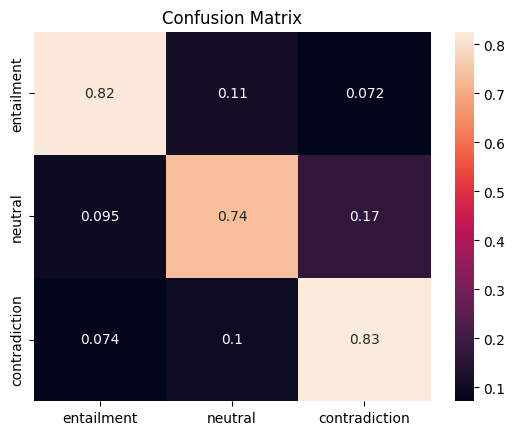

Epoch: 01 | Epoch Time: 47m 45s
	Train Loss: 0.622 | Train Acc: 73.82%
	 Val. Loss: 0.515 |  Val. Acc: 79.44%


100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.80      0.87      0.84      2861
      neutral       0.78      0.72      0.75      2507
contradiction       0.82      0.80      0.81      2632

     accuracy                           0.80      8000
    macro avg       0.80      0.80      0.80      8000
 weighted avg       0.80      0.80      0.80      8000



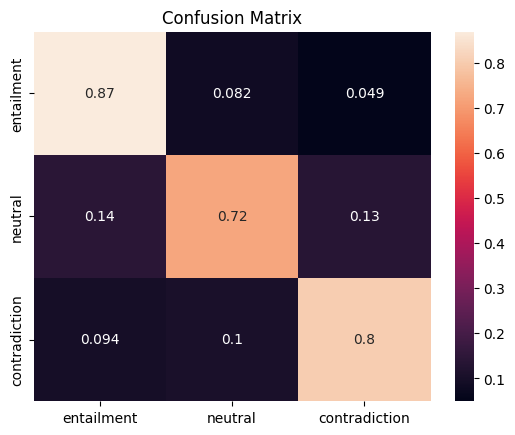

Epoch: 02 | Epoch Time: 47m 43s
	Train Loss: 0.364 | Train Acc: 86.28%
	 Val. Loss: 0.510 |  Val. Acc: 80.11%


100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.88      0.76      0.81      2861
      neutral       0.71      0.79      0.75      2507
contradiction       0.79      0.82      0.80      2632

     accuracy                           0.79      8000
    macro avg       0.79      0.79      0.79      8000
 weighted avg       0.80      0.79      0.79      8000



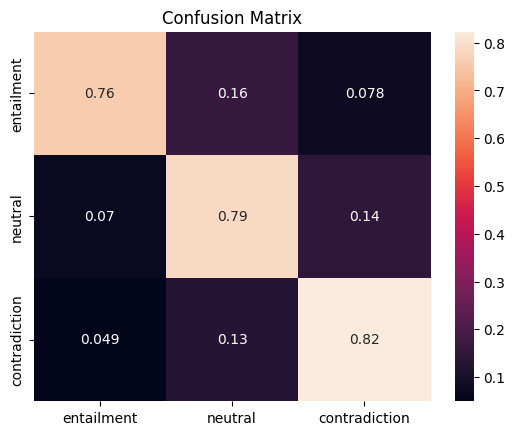

Epoch: 03 | Epoch Time: 47m 43s
	Train Loss: 0.205 | Train Acc: 92.76%
	 Val. Loss: 0.654 |  Val. Acc: 78.84%


100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.88      0.77      0.82      2861
      neutral       0.74      0.77      0.75      2507
contradiction       0.77      0.85      0.81      2632

     accuracy                           0.79      8000
    macro avg       0.79      0.79      0.79      8000
 weighted avg       0.80      0.79      0.79      8000



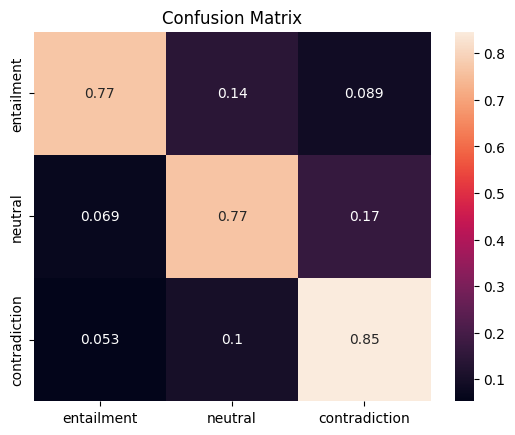

Epoch: 04 | Epoch Time: 47m 44s
	Train Loss: 0.118 | Train Acc: 95.97%
	 Val. Loss: 0.772 |  Val. Acc: 79.30%


100%|██████████| 500/500 [01:36<00:00,  5.21it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.88      0.76      0.81      2861
      neutral       0.69      0.82      0.75      2507
contradiction       0.82      0.80      0.81      2632

     accuracy                           0.79      8000
    macro avg       0.80      0.79      0.79      8000
 weighted avg       0.80      0.79      0.79      8000



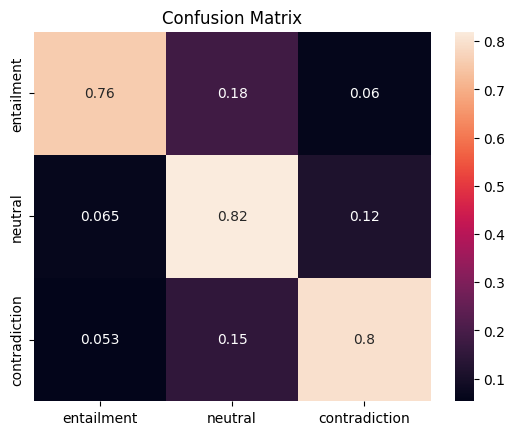

Epoch: 05 | Epoch Time: 47m 41s
	Train Loss: 0.087 | Train Acc: 97.07%
	 Val. Loss: 0.810 |  Val. Acc: 78.91%


100%|██████████| 500/500 [01:34<00:00,  5.26it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.84      0.81      0.83      2861
      neutral       0.73      0.77      0.75      2507
contradiction       0.81      0.81      0.81      2632

     accuracy                           0.80      8000
    macro avg       0.80      0.80      0.80      8000
 weighted avg       0.80      0.80      0.80      8000



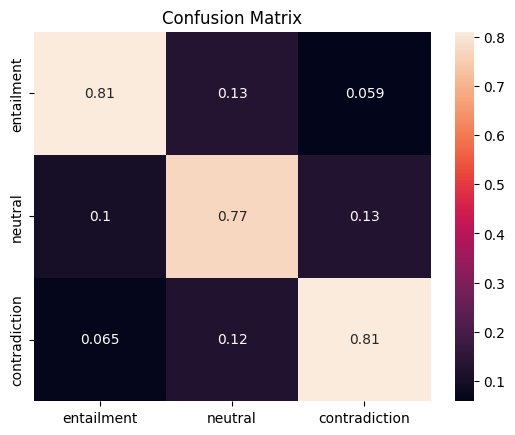

Epoch: 06 | Epoch Time: 47m 40s
	Train Loss: 0.065 | Train Acc: 97.76%
	 Val. Loss: 0.910 |  Val. Acc: 79.70%


In [31]:
import math
N_EPOCHS = 6

warmup_percent = 0.2
total_steps = math.ceil(N_EPOCHS*len(train_data)*1./BATCH_SIZE)
warmup_steps = int(total_steps*warmup_percent)
scheduler = get_scheduler(optimizer, warmup_steps)

best_valid_loss = float('inf')
best_epoch=0

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, scheduler)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch=epoch
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLPProject/models/bertmore-mnli_{epoch}.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.80      0.88      0.84      2853
      neutral       0.78      0.73      0.76      2492
contradiction       0.85      0.81      0.83      2655

     accuracy                           0.81      8000
    macro avg       0.81      0.81      0.81      8000
 weighted avg       0.81      0.81      0.81      8000



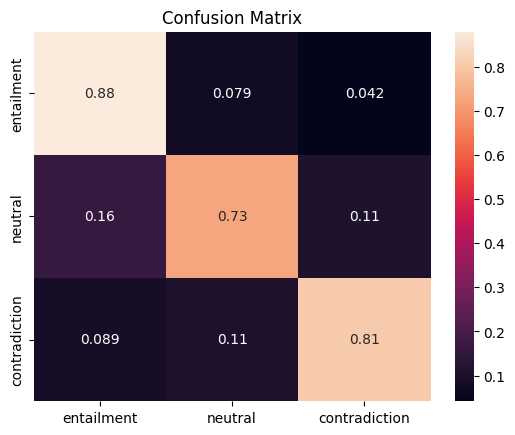

Test Loss: 0.499 |  Test Acc: 80.91%


In [32]:
model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/NLPProject/models/bertmore-mnli_{best_epoch}.pt'))

test_loss, test_acc = evaluate(model, test_dataloader, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

In [33]:
index2label={0:"entailment",1:"neutral",2:"contradiction"}
def predict_inference(premise, hypothesis, model, device):
    
    model.eval()
    
    premise = '[CLS] ' + premise + ' [SEP]'
    hypothesis = hypothesis + ' [SEP]'
    
    prem_t = tokenize_bert(premise)
    hypo_t = tokenize_bert(hypothesis)
    
    #print(len(prem_t), len(hypo_t))
    
    prem_type = get_sent1_token_type(prem_t)
    hypo_type = get_sent2_token_type(hypo_t)
    
    #print(len(prem_type), len(hypo_type))
    
    indexes = prem_t + hypo_t
    
    indexes = tokenizer.convert_tokens_to_ids(indexes)
    #print(indexes)
    indexes_type = prem_type + hypo_type
    #print(indexes_type)
    
    attn_mask = get_sent2_token_type(indexes)
    #print(attn_mask)
    
    #print(len(indexes))
    #print(len(indexes_type))
    #print(len(attn_mask))

    #seq = '[CLS] '+ premise + ' [SEP] '+ hypothesis 

    #tokens = tokenizer.tokenize(seq)

    #indexes = tokenizer.convert_tokens_to_ids(tokens)
    
    indexes = torch.LongTensor(indexes).unsqueeze(0).to(device)
    indexes_type = torch.LongTensor(indexes_type).unsqueeze(0).to(device)
    attn_mask = torch.LongTensor(attn_mask).unsqueeze(0).to(device)
    
    #print(indexes.size())
    
    prediction = model(indexes, attn_mask, indexes_type)
    
    prediction = prediction.argmax(dim=-1).item()
    
    return index2label[prediction]

In [34]:
premise = 'a man sitting on a green bench.'
hypothesis = 'a woman sitting on a green bench.'

predict_inference(premise, hypothesis, model, device)

'contradiction'

In [35]:
premise = 'a man sitting on a green bench.'
hypothesis = 'a man sitting on a blue bench.'

predict_inference(premise, hypothesis, model, device)

'contradiction'

In [36]:
premise = 'I am lying down on bed.'
hypothesis = 'I am resting on bed.'

predict_inference(premise, hypothesis, model, device)

'entailment'

In [37]:
premise = 'I go to office on my personal car.'
hypothesis = 'I have to share office cab for reaching office.'

predict_inference(premise, hypothesis, model, device)

'contradiction'

In [38]:
premise = 'I love to play cricket.'
hypothesis = 'I enjoy playing football.'

predict_inference(premise, hypothesis, model, device)

'contradiction'

In [39]:
premise = 'He is techy.'
hypothesis = 'He has no idea of tech.'

predict_inference(premise, hypothesis, model, device)

'contradiction'

In [40]:
premise = 'I am using mobile phone.'
hypothesis = 'I have mobile in my hand.'

predict_inference(premise, hypothesis, model, device)

'entailment'